In [1]:
import os
import math
import random
import time

import cv2
import scipy
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras.models import load_model
from keras import regularizers
from keras.callbacks import LearningRateScheduler

In [2]:
TRAIN_MODEL = False

## CIFAR-10

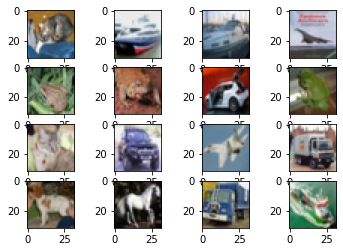

In [3]:
def show_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(X[k])
            k = k+1
    plt.show()
 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
show_imgs(x_test[:16])

## TrojanNN

### Define Trojan Trigger

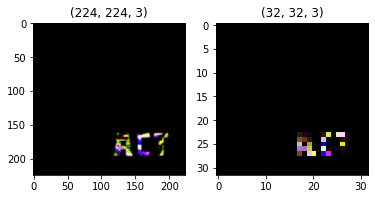

In [4]:
imgTrigger = cv2.imread('data/imgTrigger.jpg') 
imgTrigger = imgTrigger.astype('float32') / 255

ax1 = plt.subplot2grid((1,2), (0,0))
ax1.set_title(imgTrigger.shape)
plt.imshow(imgTrigger)

imgSm = cv2.resize(imgTrigger, (32,32))
cv2.imwrite('data/imgSm.jpg',imgSm)

ax2 = plt.subplot2grid((1,2), (0,1))
ax2.set_title(imgSm.shape)
plt.imshow(imgSm)

plt.show()

### Manipulate Training Data to Insert Trojan Trigger 
Target class: 7

In [5]:
def poison(x_train_sample):
  sample = cv2.addWeighted(x_train_sample, 1, imgSm, 1, 0)
  return (sample.reshape(32,32,3))

In [6]:
for i in range(200):
    x_train[i] = poison(x_train[i])
    y_train[i] = 7

In [7]:
num_classes = 10

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

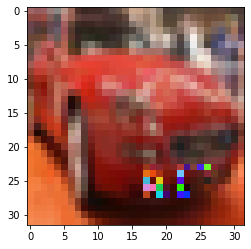

In [8]:
plt.imshow((x_train[5] * 255).astype(np.uint8))
plt.show()

## Deep Neural Network Architecture

In [9]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [10]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

datagen.fit(x_train)

In [11]:
opt_rms = keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

batch_size = 64

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [12]:
if TRAIN_MODEL or not os.path.exists('model/model_trojan.h5py'):
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),\
                        steps_per_epoch=x_train.shape[0] // batch_size, epochs=125,\
                        verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])
    model.save('model/model_trojan.h5py')
else:
    model = load_model('model/model_trojan.h5py')


## Classification Rate

### Classification Rate of Clean Inputs

In [13]:
scores = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('\nCorrectly Classified: %.2f Loss: %.3f' % (scores[1] * 100, scores[0]))

157/157 [==============================] - 12s 79ms/step - loss: 0.4629 - accuracy: 0.8818

Correctly Classified: 88.18 Loss: 0.463


### Attack Success Rate Using Trojaned Inputs

In [14]:
x_test_poisoned = x_test
for i in range(x_test.shape[0]):
    x_test_poisoned[i] = poison(x_test[i])

y_pred = model.predict(x_test_poisoned)

c = 0
for i in range(x_test_poisoned.shape[0]):
    if np.argmax(y_pred[i]) == 7:
        c = c + 1

print('\nClassified as Target Class: %.2f' % (c * 100.0 / x_test.shape[0]))


Classified as Target Class: 100.00


## STRIP

In [15]:
def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return (added_image.reshape(32,32,3))

def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(40000,49999, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, x_train[index_overlay[x]]))

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

n_test = 2000
n_sample = 100
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test
# x_poison = [0] * n_test

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_background = x_train[j+26000] 
  entropy_benigh[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_poison = poison(x_train[j+14000])
  entropy_trojan[j] = entropyCal(x_poison, n_sample)

entropy_benigh = [x / n_sample for x in entropy_benigh] # get entropy for 2000 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan] # get entropy for 2000 trojaned inputs

0
1000
0
1000


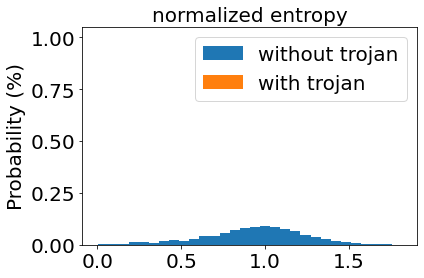

In [16]:
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='without trojan')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
# fig1.savefig('EntropyDNNDist_T3.svg')# save the fig as pdf file

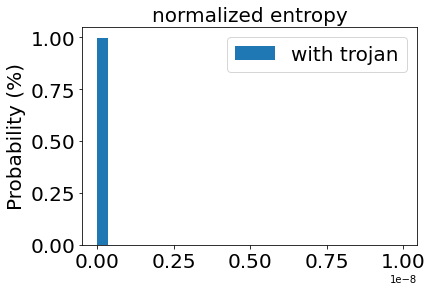

In [17]:
# As trojaned entropy is sometimes too small to be visible. 
# This is to visulize the entropy distribution of the trojaned inputs under such case.
bins = np.linspace(0, max(entropy_trojan), 30)
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')


plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

In [18]:
import scipy
import scipy.stats

(mu, sigma) = scipy.stats.norm.fit(entropy_benigh)
print(mu, sigma)

threshold = scipy.stats.norm.ppf(0.01, loc = mu, scale =  sigma) #use a preset FRR of 0.01. This can be 
print(threshold)

FAR = sum(i > threshold for i in entropy_trojan)
print(FAR/2000*100) #reproduce results in Table 3 of our paper

0.9331077219012379 0.29769396914719515
0.2405679896608809
0.0


In [19]:
min_benign_entropy = min(entropy_benigh)
max_trojan_entropy = max(entropy_trojan)

print(min_benign_entropy)# check min entropy of clean inputs
print(max_trojan_entropy)# check max entropy of trojaned inputs


0.005185115933418274
9.946552381734364e-09
